# 2 Make People object

This file creates a `People` object with the GREASYPOP agents and contact matrices. Covasim stores agents in an object called `People` which contains agent attributes and methods for changing agents from one infection state to another. The `People` object can be saved in a `.ppl` file that can be loaded into a simulation later. See the [Covasim Tutorial 4 - People and data](https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_people.html) and the [Covasim documentation](https://docs.idmod.org/projects/covasim/en/latest/api/_autosummary/covasim.people.People.html#covasim.people.People) on `People` to learn more.

**Input files**
- `people_all.csv`
- `gplayer_s.csv`
- `gplayer_w.csv`
- `gplayer_h.csv`
- `gplayer_c.csv`
- `gplayer_g.csv`

**Output files**
- `greasypop.ppl`
- `greasypop_ppl.png`
- `hybrid_ppl.png`
- `random_ppl.png`


In [1]:
# Import packages and set path
import covasim as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sciris as sc

path = "/Users/hamilaj1/Desktop/Covasim-G/data"

Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


## 2.1 Read in GREASYPOP agents and attributes
First, read in `people_all.csv` and preview the data. You may get a message that some columns have mixed data types. This is okay.

In [2]:
people = pd.read_csv(f'{path}/people_all.csv',low_memory=False).drop(columns=['Unnamed: 0']) # Read in people_all.csv
people.head() # Preview data

,p_id,hh_id,cbg_id,uid,sample_index,age,female,working,commuter,commuter_income_category,commuter_workplace_category,race_black_alone,white_non_hispanic,hispanic,sch_grade,sex,cbg_geocode,state,county
0,1,636,3879,0,2554510.0,45.0,1.0,1.0,0.0,NaN,NaN,0.0,1.0,0.0,NaN,0.0,2.403171e+11,24,24031
1,1,850,4915,1,2575249.0,50.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,NaN,1.0,2.403788e+11,24,24037
2,4,552,2920,2,2563912.0,21.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,1.0,2.401351e+11,24,24013
3,1227,0,1711,3,0.0,30.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.100100e+11,11,11001
4,2,113,5593,4,2470655.0,56.0,1.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,NaN,0.0,2.451026e+11,24,24510


## 2.2 Make Covasim People object
Now make a sim that is the same length as the number of people in your GREASYPOP population. Set the `pop_type` as 'random' for now (we will replace this with the GREASYPOP agents after). Then make the `People` object using Covasim's `make_people` class. See the [Covasim documentation](https://docs.idmod.org/projects/covasim/en/latest/api/_autosummary/covasim.population.make_people.html) to learn. 

In [3]:
sim = cv.Sim(pop_size = len(people), pop_type='random') # Make the sim
sim.people = cv.make_people(sim) # Make the People object
sim.people.contacts # Preview the random contact layer. It's only one layer called 'a'

Contacts(a)

"a": Layer("a", p1, p2, beta)
               p1       p2  beta
0               0  1549586   1.0
1               0  9139357   1.0
2               0  7229596   1.0
3               0  1053251   1.0
4               0  2202161   1.0
...           ...      ...   ...
94235066  9424030  4068093   1.0
94235067  9424030  2560872   1.0
94235068  9424030  3168371   1.0
94235069  9424030  8039347   1.0
94235070  9424030  9230059   1.0

[94235071 rows x 3 columns]

Next, replace the agent attributes in the `People` object with those from your GREASYPOP population. Each attribute is stored as an array that is the same length as the number of people in your population.

In [4]:
sim.people.uid = people['uid'].to_numpy() # Make the people['uid'] column an array and add it to the sim People object
sim.people.age = people['age'].to_numpy() # Do the same for all the other attributes...
sim.people.sex = people['sex'].to_numpy()
sim.people.sch_grade = people['sch_grade'].to_numpy()
sim.people.race_black_alone = people['race_black_alone'].to_numpy() 
sim.people.white_non_hispanic = people['white_non_hispanic'].to_numpy() 
sim.people.hispanic = people['hispanic'].to_numpy() 
sim.people.working = people['working'].to_numpy()
sim.people.commuter = people['commuter'].to_numpy()
sim.people.commuter_income_category = people['commuter_income_category'].to_numpy()
sim.people.commuter_workplace_category = people['commuter_workplace_category'].to_numpy()
sim.people.state = people['state'].to_numpy()
sim.people.county = people['county'].to_numpy() 
sim.people.cbg_geocode = people['cbg_geocode'].to_numpy() 

## 2.3 Add GREASYPOP contact layers
Now we will replace the random contact layer with the GREASYPOP layers (household, school, workplace, group quarters) using Covasim's `Layer` class. See the Covasim [Tutorial 11 - Advanced features](https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_advanced.html) and the [Covasim documentation](https://docs.idmod.org/projects/covasim/en/latest/api/_autosummary/covasim.base.Layer.html) to learn more. The function in the next cell creates a layer from each `gplayer_[].csv` file.

In [5]:
def addLayer(gplayer):
    gplayer = f'gplayer_{key}.csv' # Set file name
    matrix = pd.read_csv(f'{path}/gplayer_{key}.csv') # Read in file
    matrix['beta'] = 1 # Add a column called 'beta' that is a series of ones
    matrix_p1 = matrix['p1'] # Make a series from the 'p1' column
    matrix_p2 = matrix['p2'] # Make a series from the 'p2' column
    matrix_beta = matrix['beta'] # Make a series from the 'beta' column
    layer = cv.Layer(p1=matrix_p1, p2=matrix_p2, beta=matrix_beta,label=f'{key}') # Use Layer class to make the Layer object
    sim.people.contacts.add_layer(key=layer) # Add the layer to the contacts dictionary of the People object
    sim.reset_layer_pars() # Reset the People object layers so your new layers are stored

In the next cell, loop through the list `keys` to run the function for each layer and add it to the contacts dictionary of the `People` object.

In [6]:
sim.people.contacts.clear() # Clear existing random 'a' layer

keys = ['h','s','w','g'] # c=community, h=household, s=school, w=workplace, g=group quarters
for key in keys: # Loop through each layer
    addLayer(f'gplayer_{key}.csv') # Run the addLayer function on the file
    sim_contacts = sim.people.contacts # Make a dictionary from this layer in the contacts dictionary
    sim_contacts[f'{key}'] = sim_contacts.pop('key') # Label the dictionary with the key
sim.reset_layer_pars() # Reset the layers so your new ones are stored
sim.people.contacts # Preview the new contact layers

Contacts(h, s, w, g)

"h": Layer("h", p1, p2, beta)
               p1       p2  beta
0           35280     2683   1.0
1           69386    40221   1.0
2           80973    48343   1.0
3           86183    16268   1.0
4           95911    25980   1.0
...           ...      ...   ...
11006686  9083959  1519806   1.0
11006687  9083959  3025185   1.0
11006688  9083959  5294285   1.0
11006689  9083959  6791598   1.0
11006690  9083960  5294287   1.0

[11006691 rows x 3 columns]

"s": Layer("s", p1, p2, beta)
               p1       p2  beta
0            1893     1601   1.0
1            2240     2053   1.0
2            4863     2292   1.0
3            5457     3305   1.0
4            6110     4409   1.0
...           ...      ...   ...
10562452  9094273  4520835   1.0
10562453  9094273  4965583   1.0
10562454  9094273  5311145   1.0
10562455  9094273  6076471   1.0
10562456  9094273  7680272   1.0

[10562457 rows x 3 columns]

"w": Layer("w", p1, p2, beta)
               p1       p2  beta
0  

Now create a 'community' layer to represent interactions outside the other layers, such as going to the grocery store, a gas station, or a restaurant. It is very difficult to generate these types of interactions with spatial data due to a lack of data. Therefore, we will approximate interactions outside the other layers using random mixing with a mean number of contacts of 4. This is equivalent to a random network with an average degree of 4. See the Covasim Tutorial 11 - [Advanced Features](https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_advanced.html) to learn more about defining new contact layers.

In [7]:
n_people = len(sim.people) # Create an array of uid's
n_contacts_per_person = 2.0 # This means the network will have an average degree of 4
n = int(n_people * n_contacts_per_person) # Generate the number of contacts
p1 = np.random.randint(n_people, size=n) # Randomly choose people for p1
p2 = np.random.randint(n_people, size=n) # Randomly choose people for p2
beta = np.ones(n) # Each contact has a weight of one
layer = cv.Layer(p1=p1, p2=p2, beta=beta, label='c') # Create the layer

sim.people.contacts.add_layer(c=layer) # Add the layer to people.contacts
sim.reset_layer_pars() # Reset layer parameters
sim.people.contacts # Preview all the layers with a new 'c' layer for community

Contacts(h, s, w, g, c)

"h": Layer("h", p1, p2, beta)
               p1       p2  beta
0           35280     2683   1.0
1           69386    40221   1.0
2           80973    48343   1.0
3           86183    16268   1.0
4           95911    25980   1.0
...           ...      ...   ...
11006686  9083959  1519806   1.0
11006687  9083959  3025185   1.0
11006688  9083959  5294285   1.0
11006689  9083959  6791598   1.0
11006690  9083960  5294287   1.0

[11006691 rows x 3 columns]

"s": Layer("s", p1, p2, beta)
               p1       p2  beta
0            1893     1601   1.0
1            2240     2053   1.0
2            4863     2292   1.0
3            5457     3305   1.0
4            6110     4409   1.0
...           ...      ...   ...
10562452  9094273  4520835   1.0
10562453  9094273  4965583   1.0
10562454  9094273  5311145   1.0
10562455  9094273  6076471   1.0
10562456  9094273  7680272   1.0

[10562457 rows x 3 columns]

"w": Layer("w", p1, p2, beta)
               p1       p2  beta


## 2.4 Save the GREASYPOP People object
Finally, store the new GREASYPOP `People` object so you can load it into your sims later. It takes less time to load a population than to make it again.

In [8]:
sim.people.save(f'{path}/greasypop.ppl')

'/Users/hamilaj1/Desktop/Covasim-G/data/greasypop.ppl'

## 2.5 Comparing population types
Covasim has a built in function for viewing the statistics of the sim population. You can use this to compare the GREASYPOP population to a 'random' or 'hybrid' `pop_type` for the same location as your GREASYPOP population. We do this below with the example of the state of Maryland, USA. You can see a list location options by running `cv.data.show_locations()`. Learn more about pop_types from [Covasim Tutorial 4 - People and data](https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_people.html).
#### 2.5.1 GREASYPOP population

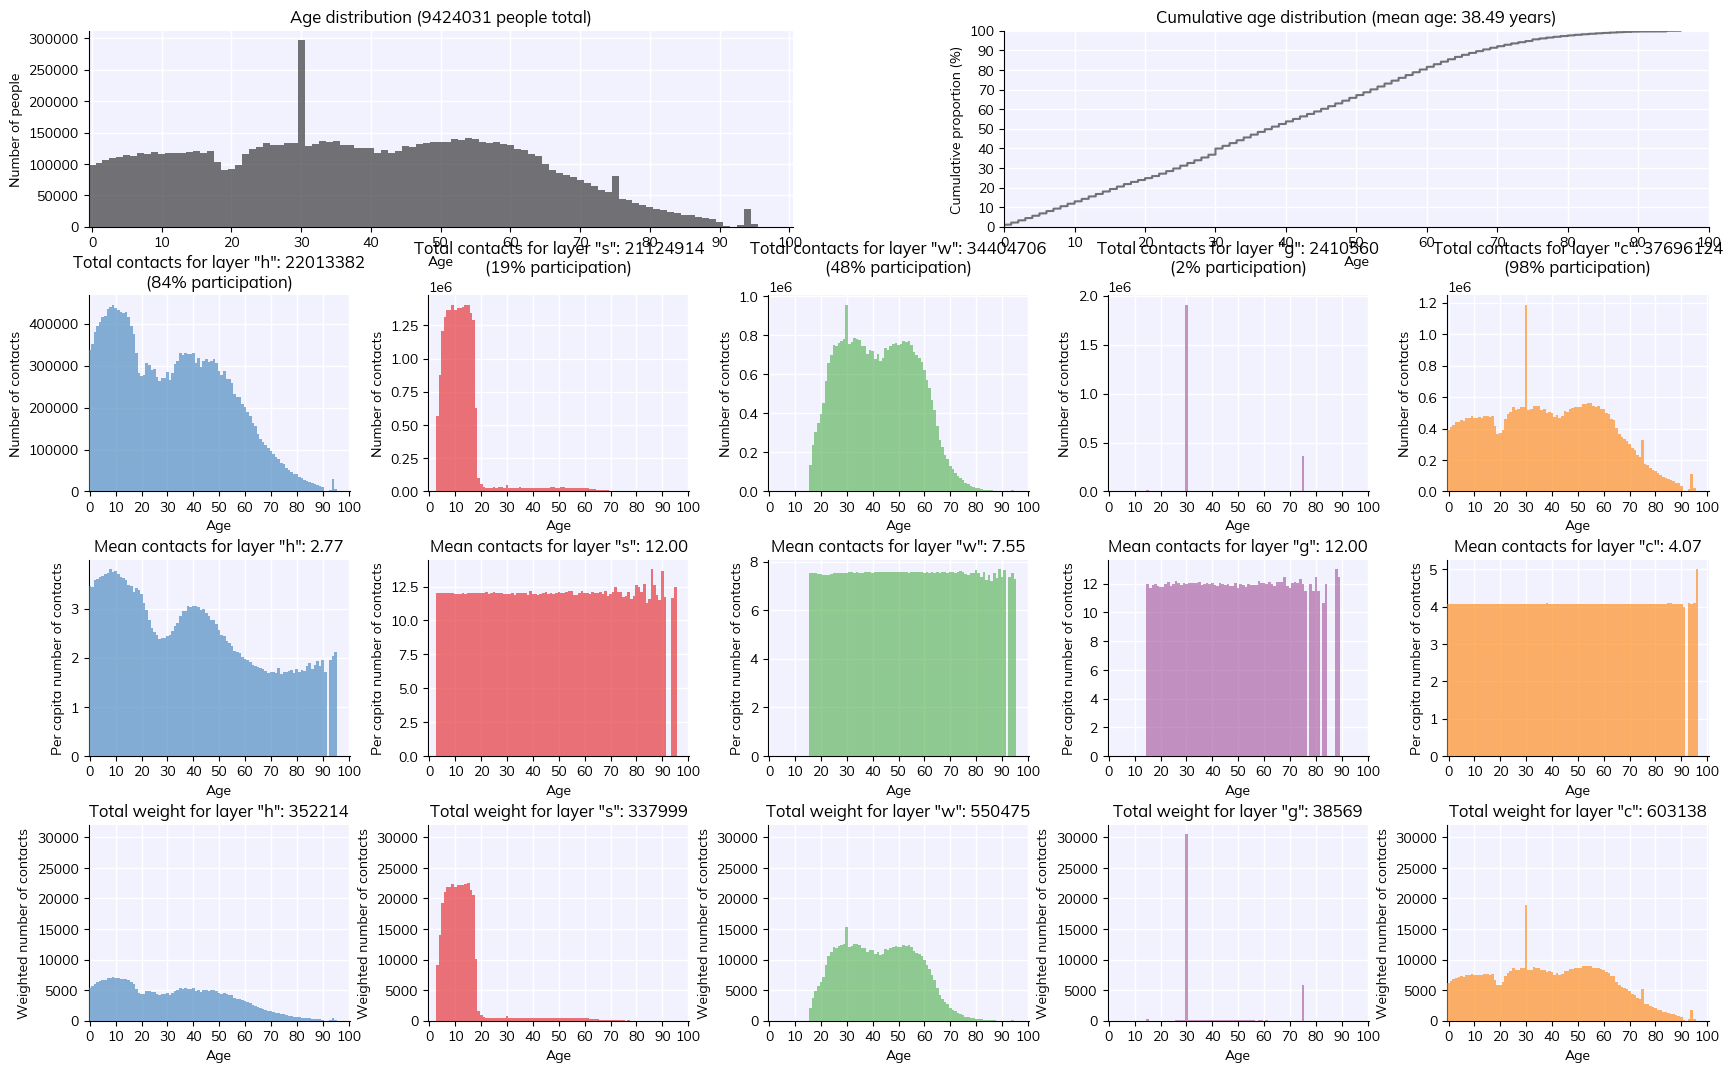

In [9]:
sim.people.plot().savefig(f'{path}/greasypop_ppl.png') # View and save stats for the GREASYPOP population

#### 2.5.2 Hybrid population
The hybrid population type has four contact layers called 'h', 's', 'w', and 'c' for 'household', 'school', 'workplace', and 'community'. You will notice that compared to the GREASYPOP population, the hybrid population has more contacts and higher mean number of contacts per layer.

Loading location-specific data for "USA-Maryland"


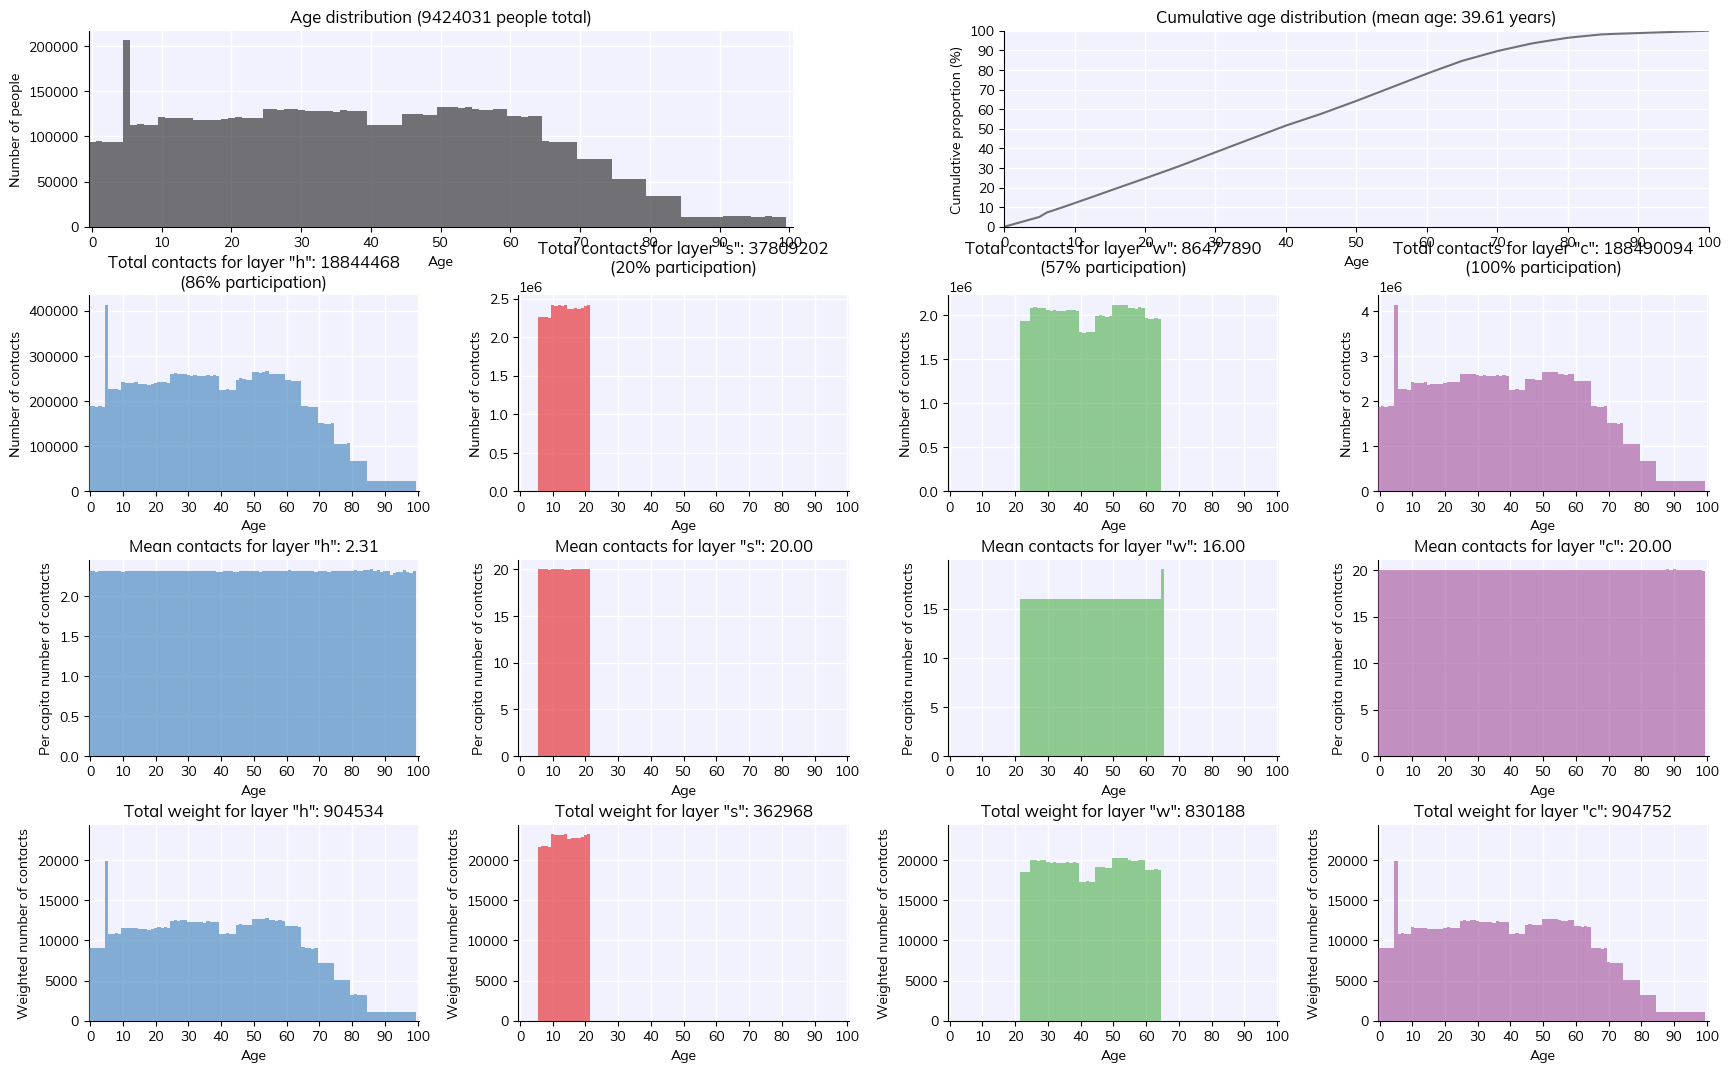

In [10]:
sim_hybrid = cv.Sim(pop_size = len(people), pop_type='hybrid', location='USA-Maryland') # Make a sim with a hybrid pop_type 
                                                                                        # and set your location.
                                                                                        # This may take a while
sim_hybrid.people = cv.make_people(sim_hybrid) # Make the people object
sim_hybrid.people.plot().savefig(f'{path}/hybrid_ppl.png') # View and save stats for the hybrid population

#### 2.5.3 Random population
The random population type only has one contact layer called 'a' and sets the mean number of contacts to be 20.

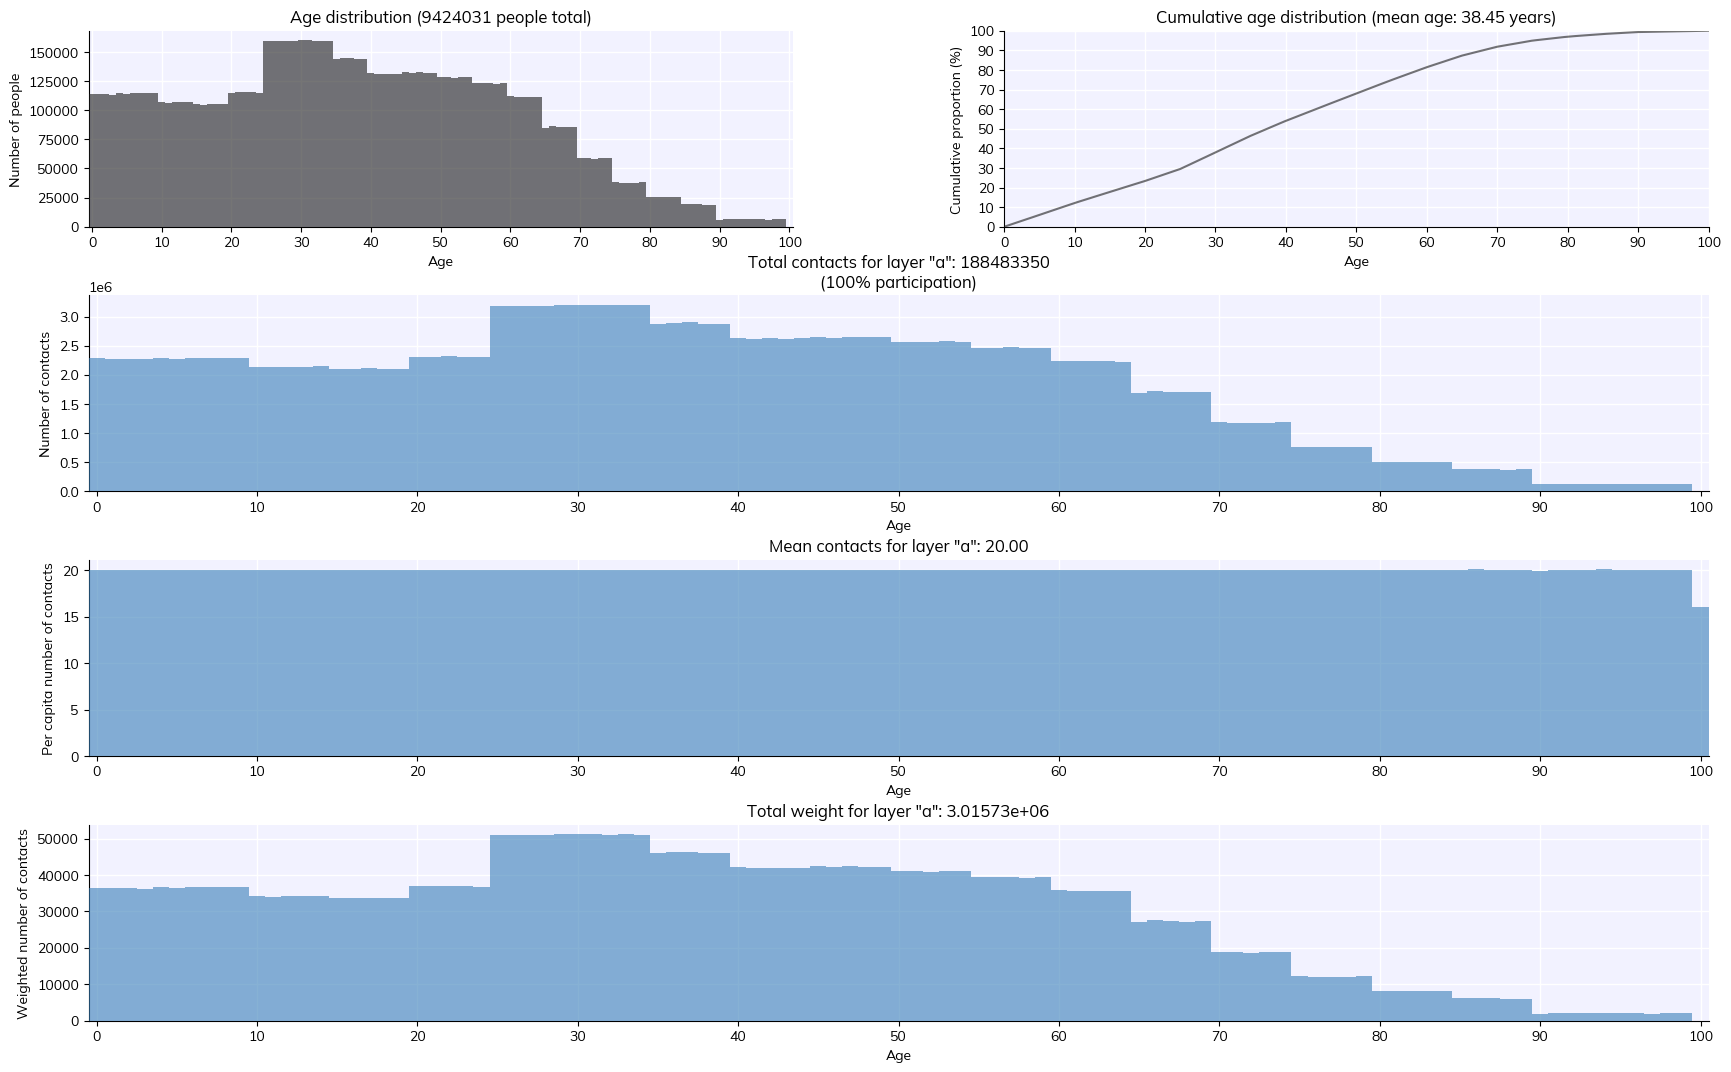

In [11]:
sim_random = cv.Sim(pop_size = len(people), pop_type='random') # Make a sim with a random pop_type
sim_random.people = cv.make_people(sim_random) # Make the people object
sim_random.people.plot().savefig(f'{path}/random_ppl.png') # View and save stats for the random population